Stock Market
=============

Step 1: Define a function to access Yahoo Finance API and extract the information for the stocks and dates requered, then store them as a csv file in the stock directory.

In [7]:
import yahoo_finance
import csv

columns = ['volume','symbol','adj_close','high','low','date','close','open']

def stock_dl(symbol,start,end):
    for j in symbol:
        stock = yahoo_finance.Share(j)
        history = stock.get_historical(start,end)

        with open("stock/{}.csv".format(j), "w") as toWrite:
            writer = csv.writer(toWrite,delimiter=",")
            writer.writerow(columns)
            for i in history:
                temp = []
                for a in i.keys():
                    temp.append(i[a])
                writer.writerow(temp)

Step 2: Run the previous function suplying the needed parameters. We will check major Tech companies and the SPY as baseline, use 5 years of data.

In [8]:
symbols = ['SPY','GOOGL','AAPL','TSLA','FB','MSFT']
start = '2011-09-22'
end = '2016-09-22'

stock_dl(symbol=symbols,start=start,end=end)

Step 3: Read csv files and store as pandas data frames, select subsets of data if needed.

In [54]:
import os
import pandas as pd

def symbol_to_path(symbol,base_dir="stock"):
    return os.path.join(base_dir,"{}.csv".format(str(symbol)))

def get_data(symbols,columns,start,end):
    dates = pd.date_range(start,end)
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol),index_col='date',parse_dates=True,
                              usecols=columns,na_values=['nan'])
        for i in columns:
            df_temp = df_temp.rename(columns={i:symbol+'_'+i})
        df = df.join(df_temp,how='left')
    
    df = df.dropna(subset=['SPY_adj_close'])
    
    return df
            
columns = ['adj_close','date']    
df = get_data(symbols=symbols,columns=columns,start=start,end=end)
print df.tail()
print "\nThe df is {} rows by {} columns".format(df.shape[0],df.shape[1])
    

            SPY_adj_close  GOOGL_adj_close  AAPL_adj_close  TSLA_adj_close  \
2016-09-15     214.197992       801.229980      115.570000      200.419998   
2016-09-16     213.369995       797.969971      114.919998      205.399994   
2016-09-19     213.410004       795.390015      113.580002      206.339996   
2016-09-20     213.419998       799.780029      113.570000      204.639999   
2016-09-21     215.820007       805.030029      113.550003      205.220001   

            FB_adj_close  MSFT_adj_close  
2016-09-15    128.350006       57.189999  
2016-09-16    129.070007       57.250000  
2016-09-19    128.649994       56.930000  
2016-09-20    128.639999       56.810001  
2016-09-21    129.940002       57.759998  

The df is 1258 rows by 6 columns


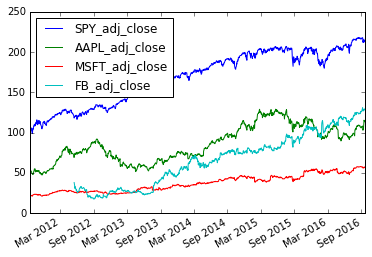

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

df[['SPY_adj_close','AAPL_adj_close','MSFT_adj_close','FB_adj_close']].plot()
plt.show()

Stock exchange often has 252 trading days per year, just a reminder.

Step 4: Normalize data, that is make it all start at 1.0 value. So you know, equality and stuff.

In [34]:
ndf = df/df.ix[0,:]

In [35]:
ndf.head()

,SPY_adj_close,GOOGL_adj_close,AAPL_adj_close,TSLA_adj_close,FB_adj_close,MSFT_adj_close
2011-09-22,1.000000,1.000000,1.000000,1.000000,NaN,1.000000
2011-09-23,1.006025,1.009315,1.006172,1.029263,NaN,1.000000
2011-09-26,1.029949,1.021569,1.003360,0.995708,NaN,1.015164
2011-09-27,1.041467,1.035878,0.993629,1.021849,NaN,1.024342
2011-09-28,1.020202,1.015711,0.988029,0.959423,NaN,1.020750


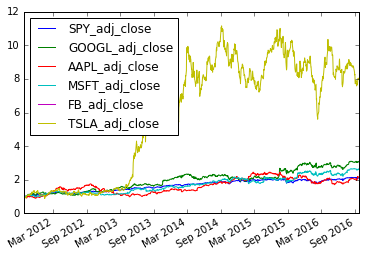

In [36]:
ndf[['SPY_adj_close','GOOGL_adj_close','AAPL_adj_close','MSFT_adj_close','FB_adj_close','TSLA_adj_close']].plot()
plt.show()

But what happened to FB? Since it had a NaN value in the position 0, we cannot visualize it normalized (yet at least). We include Google and Tesla which were not included last time. Wow Tesla, wow.

Lets fill the missing information of FB, first filling backward, then forward.

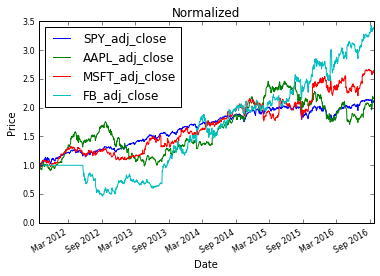

In [70]:
df.fillna(method='ffill',inplace='TRUE')
df.fillna(method='bfill',inplace='TRUE')
ndf = df/df.ix[0,:]

ax = ndf[['SPY_adj_close','AAPL_adj_close','MSFT_adj_close','FB_adj_close']].plot(title='Normalized',fontsize=8)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

Step 5: Rocking & Rolling statistics...

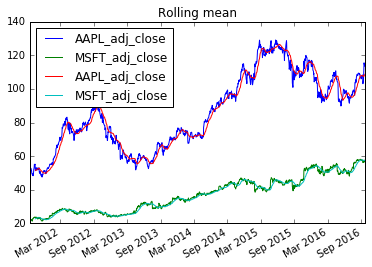

In [80]:
rmdf = df.rolling(window=20,center=False).mean()

ax = df[['AAPL_adj_close','MSFT_adj_close']].plot(title='Rolling mean')
rmdf[['AAPL_adj_close','MSFT_adj_close']].plot(ax=ax)
plt.show()

Step 6: Calculate Bollinger Bands(R)

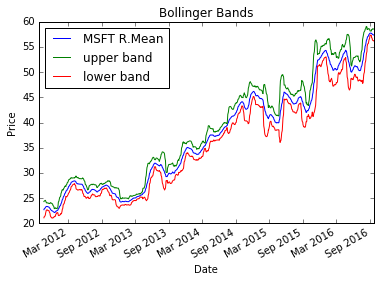

In [85]:
rsdf = df.rolling(window=20,center=False).std()
upperband = rmdf+2*rsdf
lowerband = rmdf-2*rsdf

ax = rmdf['MSFT_adj_close'].plot(label='MSFT R.Mean',title='Bollinger Bands')
upperband['MSFT_adj_close'].plot(label='upper band',ax=ax)
lowerband['MSFT_adj_close'].plot(label='lower band',ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')
plt.show()

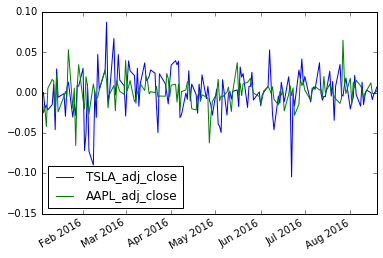

In [100]:
def time_slice(df,start,end):
    start = df.index.searchsorted(start)
    end = df.index.searchsorted(end)
    return df.ix[start:end]

dailyReturns = time_slice(ndf.copy(),'2016-01-01','2016-08-20')
dailyReturns[1:] = (df[1:]/df[:-1].values)-1
dailyReturns.ix[0,:] = 0
ax = dailyReturns[['TSLA_adj_close','AAPL_adj_close']].plot()
plt.show()

,SPY_adj_close,GOOGL_adj_close,AAPL_adj_close,TSLA_adj_close,FB_adj_close,MSFT_adj_close
2016-08-01,-0.000829,0.012131,0.017657,-0.020359,0.002985,-0.001764
2016-08-02,-0.006407,-0.001024,-0.014804,-0.012217,-0.009814,0.000000
2016-08-03,0.002923,-0.001500,0.012538,-0.006206,-0.004712,0.006893
2016-08-04,0.001064,-0.002090,0.006178,0.021347,0.015101,0.007372
2016-08-05,0.008179,0.012142,0.015207,-0.002515,0.006353,0.009932
2016-08-08,-0.000596,-0.002107,0.008281,-0.016824,0.000879,0.001725
2016-08-09,0.000596,0.002794,0.004060,0.012911,-0.001597,0.002411
